### Importing libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary
import albumentations as A
import importlib
from torch_lr_finder import LRFinder
from utils import utils
from utils.utils import fabric
from utils.dataset import Dataset
from utils.scheduler import Scheduler
import warnings

warnings.filterwarnings('ignore')

Using bfloat16 Automatic Mixed Precision (AMP)
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


In [2]:
# Initialize
utils.set_seed(1)

### Import dataset: CIFAR10

In [3]:
dataset = Dataset('CIFAR10', batch_size=512, trans_lib='albumentations')

# Add augmentations for training dataset
dataset.dt.set_transforms('train', [
    A.HorizontalFlip(),
    A.PadIfNeeded(min_height=40, min_width=40),
    A.RandomCrop(height=32, width=32),
    A.CoarseDropout(max_holes=1, max_height=16, max_width=16, fill_value=dataset.dt.mean)
], True)

Files already downloaded and verified
Files already downloaded and verified
The mean and SD for CIFAR10 dataset are [0.49139968 0.48215841 0.44653091] and [0.24703223 0.24348513 0.26158784] respectively.
Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_loader, test_loader = dataset.get_data_loaders()

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

### Visualize input images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


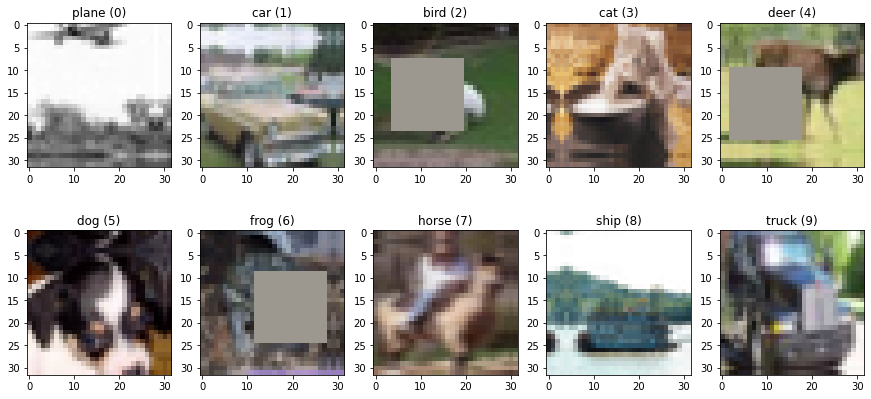

In [6]:
label_mapper = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
utils.visualize_images(images, labels, dataset.dt.mean, dataset.dt.std, label_mapper, n_cols=5, figsize=(15, 7))

### Model Training

In [7]:
from models import resnet
importlib.reload(resnet)

<module 'models.resnet' from 'd:\\Self Learning\\TSAI\\TSAI\\S11\\models\\resnet.py'>

In [8]:
from models.resnet import ResNet18
device = utils.get_device()
in_ch = 3
model = ResNet18().to(device)
summary(model, input_size=(in_ch, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

### LR Finder

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.52E-02


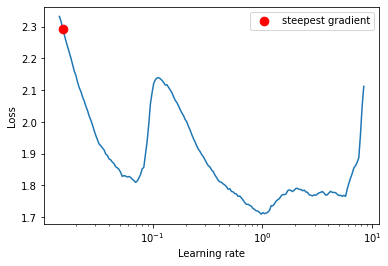

Max LR suggsted by LRFinder is 0.015167168884709228


In [9]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
_, max_lr = lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

print(f'Max LR suggsted by LRFinder is {max_lr}')

In [10]:
num_epochs = 20
steps_per_epoch = len(train_loader)

scheduler = Scheduler('OneCycleLR', {
    'optimizer': optimizer,
    'max_lr': max_lr,
    'steps_per_epoch': steps_per_epoch, 
    'epochs': num_epochs, 
    'pct_start': 5/num_epochs,
    'div_factor': 100,
    'final_div_factor': 100,
    'three_phase': False,
    'anneal_strategy': 'linear',
    'verbose': False
})

for epoch in range(1, num_epochs+1):
    print('EPOCH:', epoch)
    model.model_train(device, train_loader, criterion, optimizer, scheduler)
    model.model_test(device, test_loader, criterion)

EPOCH: 1


Train: Loss=1.5778083801269531 Batch_id=97 Accuracy=28.30: 100%|██████████| 98/98 [01:24<00:00,  1.16it/s]


Test: Average loss: 0.0031, Accuracy: 4339/10000 (43.39%), Accuracy Diff: 15.088

EPOCH: 2


Train: Loss=1.380100131034851 Batch_id=97 Accuracy=47.20: 100%|██████████| 98/98 [01:18<00:00,  1.24it/s] 


Test: Average loss: 0.0027, Accuracy: 5135/10000 (51.35%), Accuracy Diff: 4.148

EPOCH: 3


Train: Loss=1.106792688369751 Batch_id=97 Accuracy=56.23: 100%|██████████| 98/98 [01:18<00:00,  1.25it/s] 


Test: Average loss: 0.0033, Accuracy: 4815/10000 (48.15%), Accuracy Diff: 8.076

EPOCH: 4


Train: Loss=1.0652841329574585 Batch_id=97 Accuracy=62.13: 100%|██████████| 98/98 [01:21<00:00,  1.20it/s]


Test: Average loss: 0.0020, Accuracy: 6577/10000 (65.77%), Accuracy Diff: 3.642

EPOCH: 5


Train: Loss=0.8894270658493042 Batch_id=97 Accuracy=67.21: 100%|██████████| 98/98 [01:22<00:00,  1.19it/s]


Test: Average loss: 0.0019, Accuracy: 6819/10000 (68.19%), Accuracy Diff: 0.98

EPOCH: 6


Train: Loss=0.7928991913795471 Batch_id=97 Accuracy=70.77: 100%|██████████| 98/98 [01:20<00:00,  1.21it/s]


Test: Average loss: 0.0020, Accuracy: 6559/10000 (65.59%), Accuracy Diff: 5.184

EPOCH: 7


Train: Loss=0.7789225578308105 Batch_id=97 Accuracy=73.48: 100%|██████████| 98/98 [01:17<00:00,  1.26it/s]


Test: Average loss: 0.0014, Accuracy: 7634/10000 (76.34%), Accuracy Diff: 2.862

EPOCH: 8


Train: Loss=0.6964766979217529 Batch_id=97 Accuracy=75.42: 100%|██████████| 98/98 [01:19<00:00,  1.23it/s]


Test: Average loss: 0.0014, Accuracy: 7606/10000 (76.06%), Accuracy Diff: 0.642

EPOCH: 9


Train: Loss=0.6402240991592407 Batch_id=97 Accuracy=77.37: 100%|██████████| 98/98 [01:21<00:00,  1.20it/s]


Test: Average loss: 0.0014, Accuracy: 7737/10000 (77.37%), Accuracy Diff: 0.004

EPOCH: 10


Train: Loss=0.6306760311126709 Batch_id=97 Accuracy=77.96: 100%|██████████| 98/98 [01:20<00:00,  1.22it/s]


Test: Average loss: 0.0012, Accuracy: 7933/10000 (79.33%), Accuracy Diff: 1.366

EPOCH: 11


Train: Loss=0.6125118136405945 Batch_id=97 Accuracy=79.86: 100%|██████████| 98/98 [01:19<00:00,  1.24it/s] 


Test: Average loss: 0.0010, Accuracy: 8292/10000 (82.92%), Accuracy Diff: 3.064

EPOCH: 12


Train: Loss=0.46417728066444397 Batch_id=97 Accuracy=81.36: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]


Test: Average loss: 0.0010, Accuracy: 8348/10000 (83.48%), Accuracy Diff: 2.12

EPOCH: 13


Train: Loss=0.42721131443977356 Batch_id=97 Accuracy=81.90: 100%|██████████| 98/98 [01:37<00:00,  1.01it/s]


Test: Average loss: 0.0009, Accuracy: 8522/10000 (85.22%), Accuracy Diff: 3.324

EPOCH: 14


Train: Loss=0.431031733751297 Batch_id=97 Accuracy=82.87: 100%|██████████| 98/98 [01:27<00:00,  1.12it/s]  


Test: Average loss: 0.0009, Accuracy: 8418/10000 (84.18%), Accuracy Diff: 1.312

EPOCH: 15


Train: Loss=0.5419524312019348 Batch_id=97 Accuracy=83.75: 100%|██████████| 98/98 [01:22<00:00,  1.19it/s] 


Test: Average loss: 0.0009, Accuracy: 8552/10000 (85.52%), Accuracy Diff: 1.772

EPOCH: 16


Train: Loss=0.423602819442749 Batch_id=97 Accuracy=84.27: 100%|██████████| 98/98 [01:20<00:00,  1.22it/s]  


Test: Average loss: 0.0009, Accuracy: 8451/10000 (84.51%), Accuracy Diff: 0.238

EPOCH: 17


Train: Loss=0.45971307158470154 Batch_id=97 Accuracy=85.05: 100%|██████████| 98/98 [01:19<00:00,  1.24it/s]


Test: Average loss: 0.0008, Accuracy: 8673/10000 (86.73%), Accuracy Diff: 1.68

EPOCH: 18


Train: Loss=0.398418664932251 Batch_id=97 Accuracy=86.20: 100%|██████████| 98/98 [01:07<00:00,  1.45it/s]  


Test: Average loss: 0.0008, Accuracy: 8708/10000 (87.08%), Accuracy Diff: 0.884

EPOCH: 19


Train: Loss=0.41582828760147095 Batch_id=97 Accuracy=86.87: 100%|██████████| 98/98 [01:07<00:00,  1.44it/s]


Test: Average loss: 0.0007, Accuracy: 8836/10000 (88.36%), Accuracy Diff: 1.494

EPOCH: 20


Train: Loss=0.3796864151954651 Batch_id=97 Accuracy=87.95: 100%|██████████| 98/98 [01:08<00:00,  1.44it/s] 


Test: Average loss: 0.0006, Accuracy: 8937/10000 (89.37%), Accuracy Diff: 1.424



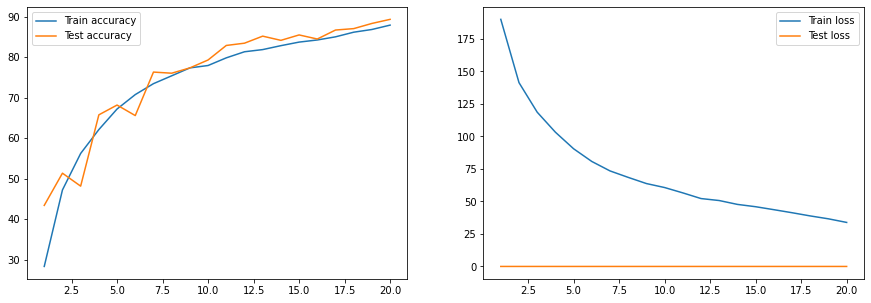

In [11]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
model.plot_accuracy()
plt.subplot(122)
model.plot_loss()
plt.savefig('images/model.png')
plt.show()

In [12]:
max(model.train_accuracy), max(model.test_accuracy)

(87.946, 89.37)

### Visualizing incorrect predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


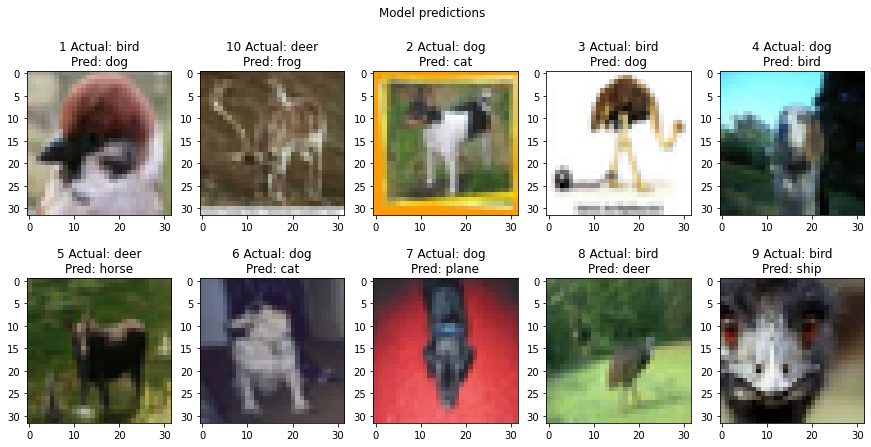

In [13]:
label_mapper = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
images, actual, pred = model.get_incorrect_pred(device, test_loader)
images, actual, pred = images.to('cpu'), actual.to('cpu'), pred.to('cpu')
labels = [str(indx + 1) + ' Actual: %s' % label_mapper[act.item()] + '\n' + \
    'Pred: %s' % label_mapper[pr.item()] for indx, (act, pr) in enumerate(zip(actual, pred))]
utils.visualize_images(images, labels, dataset.dt.mean, dataset.dt.std, n_cols=5, figsize=(15, 7), img_title='Model predictions')
plt.savefig('images/incorrect_pred.png')

### Visualizing incorrect predictions using GradCAM

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


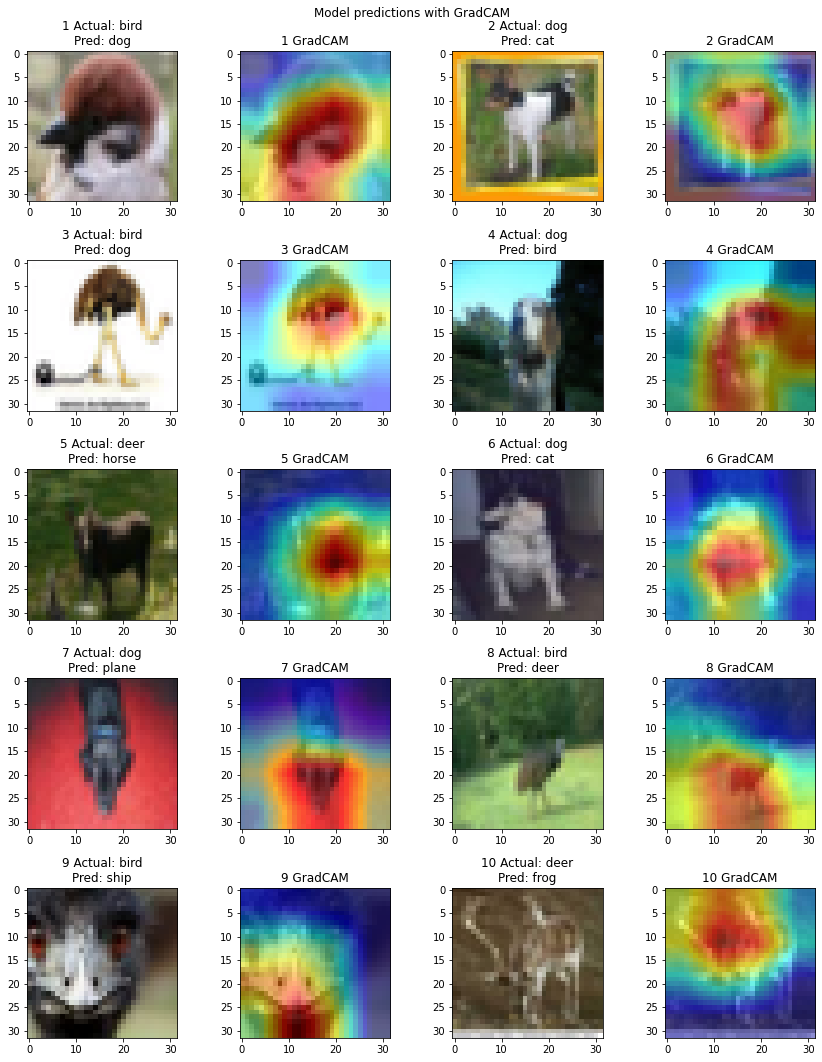

In [14]:
utils.visualize_imgs_with_gradcam(model, images, labels, pred, dataset.dt.mean, dataset.dt.std, 
    n_cols=4, figsize=(12, 15), img_title='Model predictions with GradCAM')

plt.tight_layout()
plt.savefig('images/incorrect_pred_with_gradcam.png')
plt.show()